<hr/>

# Foundations of Reinforcement Learning

<hr/>

<h1><font color="darkblue">Lab 4: Monte Carlo Method  </font></h1>





##  Content
1. Monte Carlo Method


Import Gym and other necessary libraries

In [2]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import gym
from IPython import display
import random

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1. Monte Carlo Method  (CartPole-v1 environment)

### 1.1 CartPole Introduction

We now apply Monte Carlo Method for CartPole problem. 


1. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. 

0. The system is controlled by applying a force of +1 or -1 to the cart. 

0. The pendulum starts up, and the goal is to prevent it from falling over. 

0. A reward of +1 is provided for every timestep that the pole remains up. 

0. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

0. For more info (See [SOURCE ON GITHUB](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)).

The following examples show the basic usage of this testing environment: 



### 1.1.1 Episode initialization and Initial Value

In [3]:
env = gym.make('CartPole-v0')
observation = env.reset() ##Initial an episode

print("Inital observation is {}".format(observation))

print("\nThis means the cart current position is {}".format(observation[0][0]), end = '')
print(" with velocity {},".format(observation[0][1]))

print("and the pole current angular position is {}".format(observation[0][2]), end = '')
print(" with angular velocity {},".format(observation[0][3]))


Inital observation is (array([-0.04832037,  0.02465061,  0.02842472,  0.03649355], dtype=float32), {})

This means the cart current position is -0.04832037165760994 with velocity 0.024650607258081436,
and the pole current angular position is 0.028424719348549843 with angular velocity 0.03649355471134186,


/Users/alecportelli/anaconda3/envs/Quadcopter-AI/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


### 1.1.2 Take actions


Use env.step(action) to take an action

action is an integer from 0 to 1

0: "Left"; 1: "Right"

In [4]:
print("Current observation is {}".format(observation))

action = 0 #go left
obs, reward, terminated, truncated, info = env.step(action) # simulate one step

print("\nNew observation is {}".format(observation))
print("Step reward is {}".format(reward))
print("Did episode just ends? -{}".format(terminated)) # episode ends when 3.1(6) happens



Current observation is (array([-0.04832037,  0.02465061,  0.02842472,  0.03649355], dtype=float32), {})

New observation is (array([-0.04832037,  0.02465061,  0.02842472,  0.03649355], dtype=float32), {})
Step reward is 1.0
Did episode just ends? -False


/Users/alecportelli/anaconda3/envs/Quadcopter-AI/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


### 1.1.3 Simulate multiple episodes

(You may uncomment those lines to see an animation. However, it will not work for JupyterHub since the animation requires GL instead of webGL. If you have Jupyter notebook localy on your computer, this version of code will work through a virtual frame.)

In [5]:
env = gym.make('CartPole-v0')
observation = env.reset()
total_reward = 0
ep_num = 0
# img = plt.imshow(env.render(mode='rgb_array')) 


for _ in range(1000):
    #     img.set_data(env.render(mode='rgb_array')) 
    #     display.display(plt.gcf())
    #     display.clear_output(wait=True)
    
    action = env.action_space.sample()     # this takes random actions
    obs, reward, terminated, truncated, info = env.step(action) 
       
    total_reward += reward
    


    if terminated:                         # episode just ends
        observation = env.reset()          # reset episode
        ep_num += 1

print("Average reward per episode is {}".format(total_reward/ep_num))
env.close()


Average reward per episode is 21.27659574468085


### 1.1.4 States simplification 

For convenience, we consider only cart position and pole angular position, (i.e. state dimension = 2).

Note that the observed cart position $P \in [-4.8, 4.8]$ and pole angular position $\theta \in [-0.418, 0.418]$ for all times. Then, we could evenly devide those two intervals to from a finite number of states.

In [6]:
def find_state_idx(ob,ls0,ls1):
    pos_diff = ob[0][0] +4.8
    a_pos_diff = ob[0][2] + 0.418
    
    step_size_1 = 4.8*2/(ls0-1)
    step_size_2 = 0.418*2/(ls1-1)
    
    
    d_1 = np.round(pos_diff/step_size_1)
    d_3 = np.round(a_pos_diff/step_size_2)
     
    return [d_1,d_3]


ls_cart = 100 #devide the position of cart into 100 states
ls_pole = 100 #devide the angular position of pole into 100 states

# Threre are 100 * 100 = 10000 different states in total

observation = env.reset()
state_idx = find_state_idx(observation, ls_cart, ls_pole)

print("\nThe cart current position is {}".format(observation[0][0]), end = '')
print(" and the pole current angular position is {}".format(observation[0][2]))

print("which projected to state {}".format(state_idx))


The cart current position is 0.03323473036289215 and the pole current angular position is -0.024911178275942802
which projected to state [50.0, 47.0]


### 1.2 On-policy first-visit MC control
1. Implement "On-policy first-visit MC control" algorithum in [Ch 5.4 Sutton] to choose optimal actions
2. Simulate this algorithum for 30000 episodes.
3. Devide the previous 30000 episodes into 15 sets. Plot average rewards for each sets. (i.e. plot average rewards for the first 2000 episodes, the second 2000 episodes, ..., and the 15th 2000 episodes.) 
4. Plot the heatmap for Q for each action


In [360]:
import gym
import numpy as np

# Define a function to discretize the state space
def discretize_state(state, bins):
    state_indices = []
    for i in range(len(bins)):
        if isinstance(state, tuple):
            value = state[0][i]  # Extract the element from the tuple
        else:
            value = state[i]  # Extract the element from the tuple
        state_indices.append(np.digitize(value, bins[i]))
    return tuple(state_indices)

def on_policy_mc_control(env, num_episodes, epsilon, bins):
    nA = env.action_space.n
    state_space_shape = tuple(len(b) + 1 for b in bins)
    Q = np.zeros(state_space_shape + (nA,))  # Q-table
    N = np.zeros(state_space_shape + (nA,))  # Count of first visits
    average_rewards = []                     # List of average rewards 
    current_ep_reward = 0
    total_reward = 0

    def epsilon_greedy_policy(state):
        if np.random.rand() < epsilon:
            return np.random.choice(nA)
        else:
            return np.argmax(Q[state])

    for episode in range(num_episodes):
        episode_memory = []  # Store (state, action, reward) tuples for this episode
        state = discretize_state(env.reset(), bins)
        done = False

        # While episode is happening 
        while not done:
            action = epsilon_greedy_policy(state)
            next_state, reward, done, truncated, info = env.step(action)
            next_state = discretize_state(next_state, bins)
            episode_memory.append((state, action, reward))
            state = next_state

        for t in range(len(episode_memory) - 1, -1, -1):
            state, action, reward = episode_memory[t]
            current_ep_reward = current_ep_reward + reward
            if (state, action) not in episode_memory[:t]:
                N[state][action] += 1
                Q[state][action] += (1 / N[state][action]) * (current_ep_reward - Q[state][action])

        # Update totals
        total_reward += current_ep_reward
        current_ep_reward = 0

        if episode % 2000 == 0:
            average_rewards.append(total_reward / 2000)
            print(f"On episode {episode} and the average reward for this 2000 is: {total_reward / 2000}")
            total_reward = 0

    return Q, average_rewards

if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    num_episodes = 30000
    epsilon = 0.1

    # Define state space discretization bins
    state_bins = [
        np.linspace(-2.4, 2.4, 10),
        np.linspace(-2.0, 2.0, 10),
        np.linspace(-0.418, 0.418, 10),
        np.linspace(-3.5, 3.5, 10)
    ]

    optimal_Q, average_rewards = on_policy_mc_control(env, num_episodes, epsilon, state_bins)
    print("All done building policy!")
    print(len(average_rewards))

    # Use the learned Q-table to extract the optimal policy
    optimal_policy = np.argmax(optimal_Q, axis=-1)
    print("All done extracting policy!")


/Users/alecportelli/anaconda3/envs/Quadcopter-AI/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


On episode 0 and the average reward for this 2000 is: 0.004
On episode 2000 and the average reward for this 2000 is: 95.782
On episode 4000 and the average reward for this 2000 is: 102.05
On episode 6000 and the average reward for this 2000 is: 105.627
On episode 8000 and the average reward for this 2000 is: 111.8565
On episode 10000 and the average reward for this 2000 is: 130.539
On episode 12000 and the average reward for this 2000 is: 169.82
On episode 14000 and the average reward for this 2000 is: 240.7305
On episode 16000 and the average reward for this 2000 is: 468.06
On episode 18000 and the average reward for this 2000 is: 1036.7945
On episode 20000 and the average reward for this 2000 is: 1387.21
On episode 22000 and the average reward for this 2000 is: 1568.7175
On episode 24000 and the average reward for this 2000 is: 1510.6495
On episode 26000 and the average reward for this 2000 is: 1750.923
On episode 28000 and the average reward for this 2000 is: 1739.521
All done build

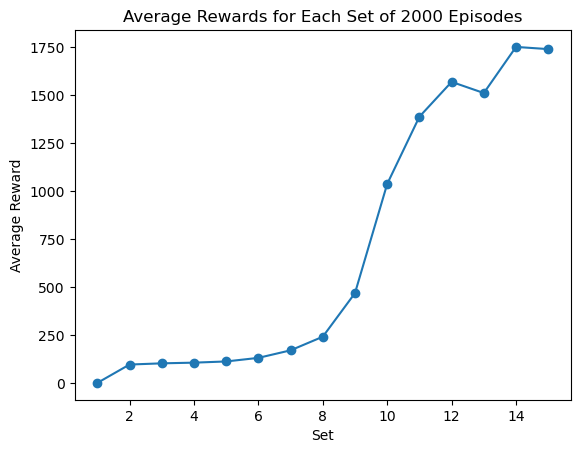

In [366]:
# Plot the average rewards for each set
plt.plot(range(1, 16), average_rewards, marker='o')
plt.title("Average Rewards for Each Set of 2000 Episodes")
plt.xlabel("Set")
plt.ylabel("Average Reward")
plt.show()

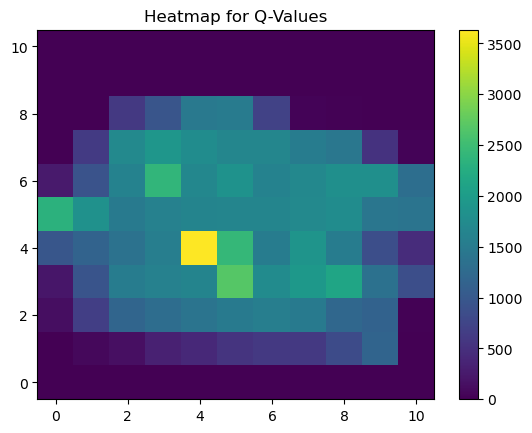

In [379]:
import numpy as np
import matplotlib.pyplot as plt

# Reshape the Q-values to a 2D array
q_values = optimal_Q.reshape(11, 11, -1).max(axis=2)

# Plot the heatmap
plt.imshow(q_values, cmap='viridis', origin='lower', aspect='auto')
plt.title("Heatmap for Q-Values")
plt.colorbar()
plt.show()
